In [1]:
pip install pymorphy3

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install WordCloud

In [3]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import pymorphy3
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from sklearn.decomposition import TruncatedSVD

import gensim
from gensim.models import CoherenceModel
import string
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [69]:
df = pd.read_csv('film2.csv')

In [70]:
df = df.drop(columns=['Unnamed: 0'])

In [71]:
df.head()

,title_russia,title_english,date,genre,duration,rating,description
0,Побег из Шоушенка,The Shawshank Redemption,1994,драма,142 мин.,9.44,"""Побег из Шоушенка"" - фильм, который считается..."
1,Крестный отец,The Godfather,1972,"драма, триллер",175 мин.,9.11,"Фильм, ставший классикой своего жанра, рассказ..."
2,Темный рыцарь,The Dark Knight,2008,"боевик, драма, кинокомикс, криминал, триллер",152 мин.,9.12,Бэтман вершит правосудие в Готэме. Его партнер...
3,Крестный отец 2,The Godfather: Part II,1974,"драма, криминал",202 мин.,8.88,Продолжение эпохальной саги режиссера Френсиса...
4,12 разгневанных мужчин,12 Angry Men,1957,"детектив, драма",96 мин.,9.15,Один из 12 присяжных в деле об убийстве пытае...


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_russia   249 non-null    object 
 1   title_english  247 non-null    object 
 2   date           249 non-null    int64  
 3   genre          249 non-null    object 
 4   duration       203 non-null    object 
 5   rating         249 non-null    float64
 6   description    249 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 13.7+ KB


In [73]:
df.describe()

,date,rating
count,249.000000,249.000000
mean,1987.361446,8.544980
std,25.404745,0.468007
min,1921.000000,6.000000
25%,1968.000000,8.330000
50%,1995.000000,8.570000
75%,2007.000000,8.840000
max,2024.000000,10.000000


In [74]:
df.shape

(249, 7)

In [75]:
df.duplicated().sum()

0

In [76]:
russian_stopwords = stopwords.words("russian") 

In [77]:
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который','свой','своём','всем','всё','её','оба','ещё','должный', "фильм", "кинокартина", "сцена", "режиссер", "актер", "мин", "кадр", "роль"]) 

In [78]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [79]:
st = '\xa0'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [80]:
def remove_punctuation(text):
    if not isinstance(text, str):
        return text
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [81]:
df['prep_text']= [remove_othersymbol(text.lower()) for text in df['description']]

In [82]:
df['prep_text']= [remove_punctuation(text) for text in df['prep_text']]

In [83]:
df

,title_russia,title_english,date,genre,duration,rating,description,prep_text
0,Побег из Шоушенка,The Shawshank Redemption,1994,драма,142 мин.,9.44,"""Побег из Шоушенка"" - фильм, который считается...",побег из шоушенка фильм который считается одни...
1,Крестный отец,The Godfather,1972,"драма, триллер",175 мин.,9.11,"Фильм, ставший классикой своего жанра, рассказ...",фильм ставший классикой своего жанра рассказыв...
2,Темный рыцарь,The Dark Knight,2008,"боевик, драма, кинокомикс, криминал, триллер",152 мин.,9.12,Бэтман вершит правосудие в Готэме. Его партнер...,бэтман вершит правосудие в готэме его партнера...
3,Крестный отец 2,The Godfather: Part II,1974,"драма, криминал",202 мин.,8.88,Продолжение эпохальной саги режиссера Френсиса...,продолжение эпохальной саги режиссера френсиса...
4,12 разгневанных мужчин,12 Angry Men,1957,"детектив, драма",96 мин.,9.15,Один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжных в деле об убийстве пытает...
...,...,...,...,...,...,...,...,...
244,Хладнокровный Люк,Cool Hand Luke,1967,"драма, криминал",127 мин.,8.00,Упорный и упрямый мужчина отказывается смирять...,упорный и упрямый мужчина отказывается смирять...
245,Это случилось однажды ночью,It Happened One Night,1934,"комедия, мелодрама",105 мин.,8.60,Испорченная богатая наследница убегает из дому...,испорченная богатая наследница убегает из дому...
246,"Париж, Техас","Paris, Texas",1984,драма,145 мин.,7.33,История уже не молодого человека по имени Трэв...,история уже не молодого человека по имени трэв...
247,Аладдин,Aladdin,1992,"комедия, мелодрама, мультфильм, мюзикл, приклю...",90 мин.,8.66,В сказочном городе Аграба живет Аладдин - вор ...,в сказочном городе аграба живет аладдин вор с ...


In [84]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [85]:
%%time
lemm_texts_list = []
for text in df['prep_text']:
    try:
        tokens = word_tokenize(text)
        res = []
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form) 
        text = " ".join(res) 
        lemm_texts_list.append(text)
    except Exception as e:
        print(f"Ошибка при обработке текста: {e}")
    
df['text_lemm'] = lemm_texts_list

CPU times: total: 1.2 s
Wall time: 1.19 s


In [86]:
def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text

In [87]:
df['tokenize_text'] = [tokenize(text) for text in df['text_lemm']]
df.head()

,title_russia,title_english,date,genre,duration,rating,description,prep_text,text_lemm,tokenize_text
0,Побег из Шоушенка,The Shawshank Redemption,1994,драма,142 мин.,9.44,"""Побег из Шоушенка"" - фильм, который считается...",побег из шоушенка фильм который считается одни...,побег из шоушенка фильм который считаться один...,побег шоушенка считаться хороший история кино ...
1,Крестный отец,The Godfather,1972,"драма, триллер",175 мин.,9.11,"Фильм, ставший классикой своего жанра, рассказ...",фильм ставший классикой своего жанра рассказыв...,фильм стать классика свой жанр рассказывать ис...,стать классика жанр рассказывать история влият...
2,Темный рыцарь,The Dark Knight,2008,"боевик, драма, кинокомикс, криминал, триллер",152 мин.,9.12,Бэтман вершит правосудие в Готэме. Его партнер...,бэтман вершит правосудие в готэме его партнера...,бэтман вершить правосудие в готэма он партнёр ...,бэтман вершить правосудие готэма партнёр стано...
3,Крестный отец 2,The Godfather: Part II,1974,"драма, криминал",202 мин.,8.88,Продолжение эпохальной саги режиссера Френсиса...,продолжение эпохальной саги режиссера френсиса...,продолжение эпохальный сага режиссёр френсиса ...,продолжение эпохальный сага режиссёр френсиса ...
4,12 разгневанных мужчин,12 Angry Men,1957,"детектив, драма",96 мин.,9.15,Один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжных в деле об убийстве пытает...,один из 12 присяжный в дело о убийство пытатьс...,12 присяжный дело убийство пытаться убедить ос...


In [88]:
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

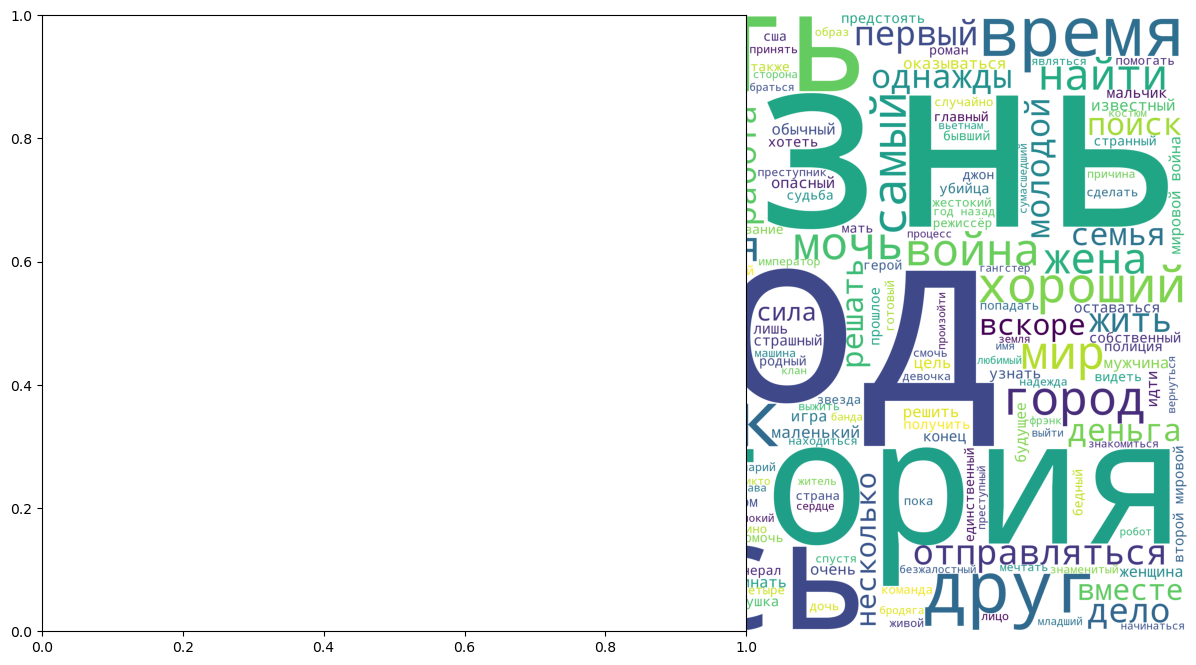

In [89]:
corpus = get_corpus(df['tokenize_text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [90]:
def get_wordCloud2(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(corpus)
    return wordCloud

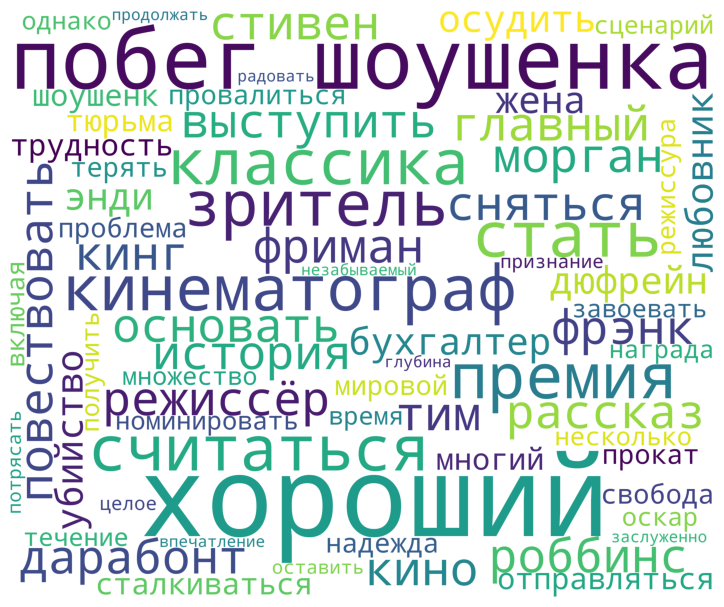

In [91]:
corpus = df['tokenize_text'][0]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

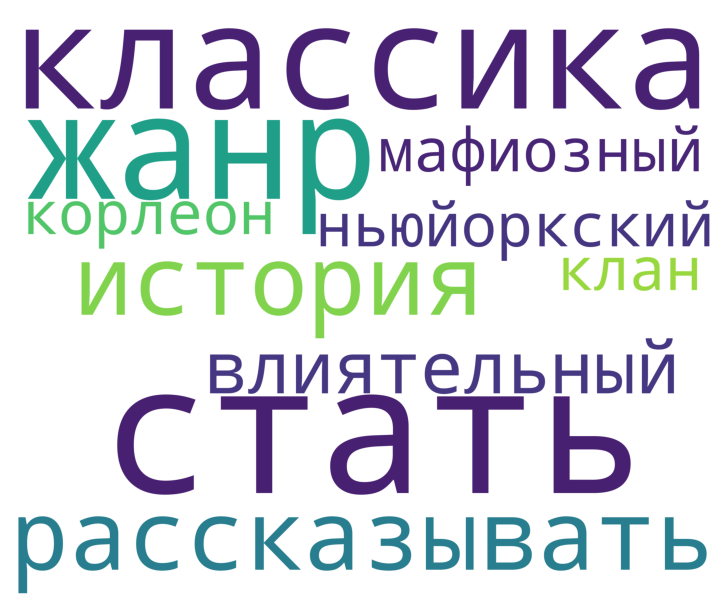

In [92]:
corpus = df['tokenize_text'][1]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

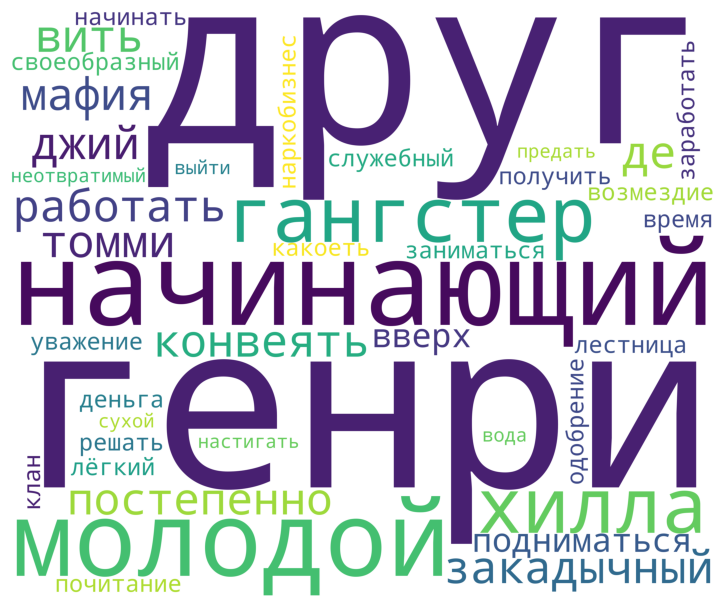

In [93]:
corpus = df['tokenize_text'][16]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

## Векторизация

In [208]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.7,
                                 min_df=5, stop_words=russian_stopwords,
                                 ngram_range=(1,2))

In [209]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokenize_text'])

In [210]:
tfidf_matrix.shape

(249, 275)

In [211]:
print(tfidf_matrix)

  (0, 267)	0.5223175907478663
  (0, 95)	0.09799967208323329
  (0, 99)	0.17183872159080907
  (0, 211)	0.16240039334243156
  (0, 266)	0.17762798218309778
  (0, 47)	0.1584434890850868
  (0, 151)	0.16240039334243156
  (0, 205)	0.17762798218309778
  (0, 258)	0.1548640337845753
  (0, 76)	0.1324117540219105
  (0, 159)	0.13057939768696658
  (0, 257)	0.1668238359605877
  (0, 192)	0.17762798218309778
  (0, 126)	0.17183872159080907
  (0, 119)	0.13433811755257588
  (0, 136)	0.14321590024442057
  (0, 251)	0.17183872159080907
  (0, 173)	0.1548640337845753
  (0, 146)	0.13433811755257588
  (0, 256)	0.17762798218309778
  (0, 31)	0.1136047098807328
  (0, 239)	0.22067384643215793
  (0, 98)	0.3168869781701736
  (0, 89)	0.3097280675691506
  (1, 95)	0.3706605047115631
  :	:
  (247, 271)	0.14283726433258223
  (247, 221)	0.23638958262625906
  (247, 268)	0.21612451331562038
  (247, 129)	0.19059354538703976
  (247, 82)	0.5444434455271913
  (247, 149)	0.19774569844977752
  (247, 232)	0.23638958262625906
  (247, 

In [212]:
tfidf_vectorizer.get_feature_names_out()[:160]

array(['агент', 'америка', 'американский', 'английский', 'банда',
       'бедный', 'безжалостный', 'битва', 'бог', 'богатый', 'бой',
       'большой', 'бороться', 'борьба', 'брат', 'браться', 'бродяга',
       'будущее', 'бывший', 'век', 'великий', 'вернуться', 'вести',
       'весь', 'видеть', 'влюбляться', 'вместе', 'военный',
       'возвращаться', 'война', 'войско', 'время', 'вскоре',
       'встретиться', 'встречать', 'второй', 'второй мировой', 'выжить',
       'выйти', 'вынудить', 'вьетнам', 'гангстер', 'генерал', 'германия',
       'герой', 'гибель', 'глава', 'главный', 'год', 'год назад',
       'голова', 'город', 'городок', 'готовый', 'гражданский',
       'гражданский война', 'группа', 'дальнейший', 'девочка', 'девушка',
       'действие', 'дело', 'день', 'деньга', 'депрессия', 'джон',
       'доллар', 'дом', 'домой', 'дорога', 'дочь', 'друг', 'друг друг',
       'еврей', 'единственный', 'желать', 'жена', 'женщина', 'жестокий',
       'живой', 'жизнь', 'житель', 'жить', 'зав

## Тематическое моделирование

In [213]:
def tokenize2(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

In [214]:
df['tokenize_text2'] = [tokenize2(text) for text in df['tokenize_text']]

In [215]:
df.head()

,title_russia,title_english,date,genre,duration,rating,description,prep_text,text_lemm,tokenize_text,tokenize_text2,cluster
0,Побег из Шоушенка,The Shawshank Redemption,1994,драма,142 мин.,9.44,"""Побег из Шоушенка"" - фильм, который считается...",побег из шоушенка фильм который считается одни...,побег из шоушенка фильм который считаться один...,побег шоушенка считаться хороший история кино ...,"[побег, шоушенка, считаться, хороший, история,...",2
1,Крестный отец,The Godfather,1972,"драма, триллер",175 мин.,9.11,"Фильм, ставший классикой своего жанра, рассказ...",фильм ставший классикой своего жанра рассказыв...,фильм стать классика свой жанр рассказывать ис...,стать классика жанр рассказывать история влият...,"[стать, классика, жанр, рассказывать, история,...",1
2,Темный рыцарь,The Dark Knight,2008,"боевик, драма, кинокомикс, криминал, триллер",152 мин.,9.12,Бэтман вершит правосудие в Готэме. Его партнер...,бэтман вершит правосудие в готэме его партнера...,бэтман вершить правосудие в готэма он партнёр ...,бэтман вершить правосудие готэма партнёр стано...,"[бэтман, вершить, правосудие, готэма, партнёр,...",0
3,Крестный отец 2,The Godfather: Part II,1974,"драма, криминал",202 мин.,8.88,Продолжение эпохальной саги режиссера Френсиса...,продолжение эпохальной саги режиссера френсиса...,продолжение эпохальный сага режиссёр френсиса ...,продолжение эпохальный сага режиссёр френсиса ...,"[продолжение, эпохальный, сага, режиссёр, френ...",0
4,12 разгневанных мужчин,12 Angry Men,1957,"детектив, драма",96 мин.,9.15,Один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжных в деле об убийстве пытает...,один из 12 присяжный в дело о убийство пытатьс...,12 присяжный дело убийство пытаться убедить ос...,"[12, присяжный, дело, убийство, пытаться, убед...",2


In [216]:
gensim_dictionary = gensim.corpora.Dictionary(df['tokenize_text2'])
gensim_dictionary.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary.compactify()

In [217]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in df['tokenize_text2']]

In [218]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 4)],
 [(4, 1), (17, 1), (24, 1)],
 [(10, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(16, 1),
  (24, 1),
  (29, 2),
  (33, 2),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1)],
 [(21, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1)],
 [(0, 1),
  (7, 1),
  (29, 1),
  (34, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(4, 1), (60, 1), (61, 1), (62, 1)],
 [(12, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1)],
 [(33, 1),
  (45, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79

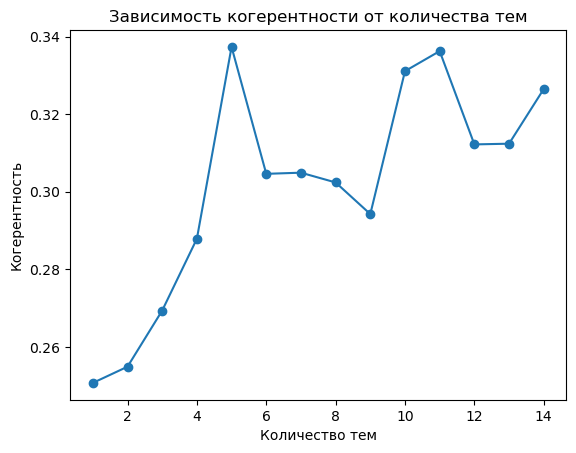

In [219]:
coherence_values = []
for num_topics in range(1, 15, 1): 
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                             num_topics=num_topics,
                             id2word=gensim_dictionary,
                             passes=10,
                             random_state=6457)
    
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=df["tokenize_text2"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
    
    coherence_values.append(coherence_model.get_coherence())

import matplotlib.pyplot as plt

plt.plot(range(1, 15, 1), coherence_values, marker='o')
plt.xlabel("Количество тем")
plt.ylabel("Когерентность")
plt.title("Зависимость когерентности от количества тем")
plt.show()

In [220]:
lda = gensim.models.LdaMulticore(corpus, 
                                 num_topics=5, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

In [221]:
lda.print_topics()

[(0,
  '0.042*"жизнь" + 0.027*"весь" + 0.025*"человек" + 0.021*"стать" + 0.020*"год" + 0.020*"история" + 0.020*"жена" + 0.018*"время" + 0.017*"путь" + 0.016*"большой"'),
 (1,
  '0.024*"жизнь" + 0.023*"год" + 0.021*"самый" + 0.021*"зритель" + 0.020*"ребёнок" + 0.019*"становиться" + 0.019*"каждый" + 0.014*"однажды" + 0.013*"жить" + 0.013*"жена"'),
 (2,
  '0.033*"друг" + 0.024*"человек" + 0.019*"дело" + 0.018*"история" + 0.017*"полицейский" + 0.015*"первый" + 0.014*"жизнь" + 0.013*"мир" + 0.013*"мочь" + 0.013*"весь"'),
 (3,
  '0.024*"сын" + 0.022*"год" + 0.021*"история" + 0.020*"последний" + 0.019*"жить" + 0.017*"отец" + 0.014*"ребёнок" + 0.013*"новый" + 0.013*"жизнь" + 0.013*"весь"'),
 (4,
  '0.044*"война" + 0.027*"стать" + 0.024*"год" + 0.021*"история" + 0.021*"весь" + 0.019*"мировой" + 0.018*"время" + 0.017*"второй" + 0.014*"молодой" + 0.014*"мальчик"')]

In [222]:
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=df["tokenize_text2"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()

print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.3366080867889388


In [223]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [224]:
vis_20 = gensimvis.prepare(lda_20, corpus, gensim_dictionary)

In [225]:
pyLDAvis.enable_notebook()

In [226]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.066708  0.059025       1        1  26.901604
4     -0.140686  0.033521       2        1  22.938051
3      0.027614 -0.143112       3        1  19.420542
0     -0.030105 -0.008104       4        1  16.681959
1      0.076469  0.058670       5        1  14.057844, topic_info=            Term       Freq      Total Category  logprob  loglift
45         война  38.000000  38.000000  Default  30.0000  30.0000
74          друг  34.000000  34.000000  Default  29.0000  29.0000
60         жизнь  51.000000  51.000000  Default  28.0000  28.0000
56     последний  11.000000  11.000000  Default  27.0000  27.0000
39           сын  19.000000  19.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
45         война   4.640710  38.064521   Topic5  -4.4582  -0.1424
0          время   4.430969  31.892564   Topic5  -4.5045  -0.0118
93       человек   3.950584  42.088523   Topic5  -4.6192  -0.4039
23       хороший   3.625317  27.374532   Topic5  -4.7051  -0.0597
24  рассказывать   3.560472  16.465436   Topic5  -4.7232   0.4306

[273 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
246       1  0.136836        «
246       2  0.136836        «
246       3  0.547344        «
246       5  0.136836        «
247       1  0.156175        »
...     ...       ...      ...
93        5  0.095038  человек
258       1  0.122051   четыре
258       3  0.122051   четыре
258       4  0.122051   четыре
258       5  0.610255   четыре

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [227]:
from sklearn.decomposition import TruncatedSVD

In [228]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: год, история, жизнь, стать, весь, человек, война, друг, время, хороший
Topic 1: история, год, война, рассказывать, мировой, стать, мировой война, второй мировой, второй, реальный
Topic 2: война, мировой война, ужас, мировой, второй, второй мировой, вьетнам, еврей, дело, происходить
Topic 3: дело, друг, человек, убийство, история, мужчина, каждый, реальный, полицейский, год
Topic 4: год, город, жить, однажды, поиск, маленький, девочка, человек, уничтожить, друг


In [229]:
from sklearn.decomposition import NMF

In [230]:
nmf_model = NMF(n_components=5, random_state=0)
nmf_model.fit(tfidf_matrix)

for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: друг, человек, город, поиск, отправляться, найти, жить, новый, вместе, отправиться
Topic 1: история, год, рассказывать, реальный, время, стать, рассказывать история, век, хороший, работать
Topic 2: война, мировой война, мировой, второй мировой, второй, ужас, вьетнам, еврей, время, самый
Topic 3: дело, убийство, полицейский, мужчина, оказываться, убийца, женщина, пытаться, каждый, расследование
Topic 4: жизнь, стать, мочь, работа, весь, ребёнок, деньга, хороший, жена, семья


In [231]:
from sklearn.decomposition import LatentDirichletAllocation

In [232]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(tfidf_matrix)

for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: весь, стать, год, город, друг, ребёнок, история, война, жизнь, мочь
Topic 1: реальный, год, история, рассказывать, маленький, война, решить, тюрьма, стать, основать
Topic 2: век, война, главный, целый, дочь, отправляться, жестокий, четыре, хороший, работа
Topic 3: новый, жизнь, убийца, полицейский, последний, известный, собственный, жена, преступник, мочь
Topic 4: человек, история, уничтожить, суд, назад, работать, год назад, убийство, военный, рассказывать


## Кластеризация

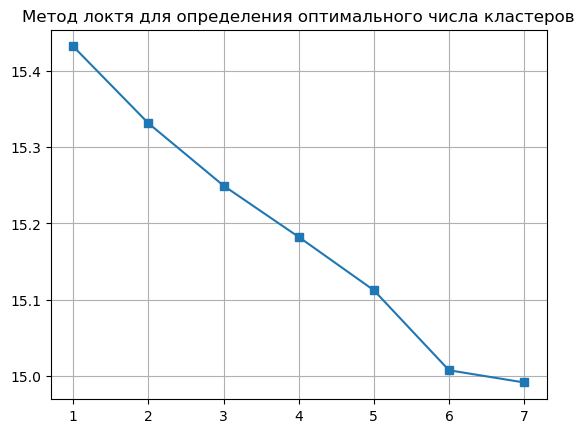

In [233]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(tfidf_matrix)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(range(1, 8), inertia, marker="s")
plt.title("Метод локтя для определения оптимального числа кластеров")
plt.grid(True)
plt.show()

In [250]:
km = KMeans(n_clusters=6)

In [251]:
km.fit(tfidf_matrix)

KMeans(n_clusters=6)

In [252]:
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [253]:
len(km.labels_)

249

In [254]:
clusters[:10]

[5, 5, 0, 1, 3, 4, 0, 5, 3, 5]

In [255]:
clusterkm = km.labels_.tolist()
df['cluster']= clusterkm

In [256]:
df['cluster'].value_counts()

cluster
1    58
2    50
5    47
0    39
3    35
4    20
Name: count, dtype: int64

In [280]:
df['tokenize_text'][df['cluster']==0]

2      бэтман вершить правосудие готэма партнёр стано...
6      близиться последний битва средиземье путь войс...
16     начинающий молодой гангстер генри хилла закады...
22     кларисса стерлинг молодой агент фбр поручить р...
36     продолжение история подросток ньюйорк майлз мо...
37     полицейский внедрять окружение мафиози фрэнк к...
45     полиция заниматься расследование причина взрыв...
53     маленький бродяга встречать улица слепой цвето...
54     противник расизм рабство доктор кинг шульц осв...
56     леонард полный решимость отомстить смерть жена...
60     ужасающий смешной система слежка восточный евр...
64     сюжет рассказывать подросток ньюйорк майлз мор...
66     джек торранс жена сын жить изолировать отель о...
86     случиться однажды америкебезумный 20е год прош...
96     кандзь ватанабэ жить остаться недолго обнаружи...
97     шесть преступник жизнь личный профессиональный...
111    мультфильм заветный мечта приключение мочь ста...
118    8летний ишан необычный р

In [281]:
tfidf_matrix_0 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 0])

In [282]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_0)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: мочь, жизнь, деньга, стать, жена, полиция, начинать, работа, самый, друг
Topic 1: жена, жизнь, начинать, деньга, работа, единственный, большой, человек, друг, самый
Topic 2: мир, стать, мочь, жизнь, большой, работа, жена, единственный, деньга, решать
Topic 3: деньга, человек, полиция, работа, жизнь, расследование, большой, стать, решать, дело
Topic 4: жена, мочь, жизнь, работа, единственный, дело, полиция, самый, начинать, расследование


криминально-социальные драмы

In [283]:
df['tokenize_text'][df['cluster']==1]

3      продолжение эпохальный сага режиссёр френсиса ...
12     обычный клерк угнести обыденный жизнь торговец...
17     бродяга решить отдохнуть государственный счёт ...
20     ангел помогать положительный весь отношение би...
26     чернокожий осудить джон коффи майкл кларк дунк...
50     команда космический грузовик ностромый выходит...
51     приковать инвалидный кресло фотограф шпионить ...
57     далёкий будущее земля напоминать больший мусор...
62     мститель стража галактика объединяться противо...
65     рассказ агат кристи полный сюрприз судебный пр...
68     спасательный капсула выжить схватка чужой элле...
70     бэтмена восемь год назад взять ответственность...
71     раскрытие секрет давать покой целый поколение ...
74     сумасшедший генерал запускать процесс « ядерны...
77     танос завладеть весь камень бесконечность поло...
80     уилла хантинг вырасти пригород бостон учиться ...
84     близко иной беда проходить мимо многа способны...
93     однажды джоэл узнать под

In [284]:
tfidf_matrix_1 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 1])

In [285]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_1)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: год, жизнь, весь, решить, сын, мужчина, пытаться, однажды, судьба, принять
Topic 1: мужчина, пытаться, однако, принять, история, жестокий, жизнь, семья, судьба, отец
Topic 2: решить, сын, отец, принять, однако, семья, судьба, маленький, история, весь
Topic 3: год, мужчина, решить, сын, отец, судьба, маленький, история, однако, пытаться
Topic 4: принять, жизнь, год, сын, жестокий, однако, отец, история, судьба, семья


In [286]:
df['tokenize_text'][df['cluster']==2]

10     форрест гампа умственно отсталый человек добры...
14     галактика идти война имперский войско находить...
15     жить серый будни очень талантливый программист...
18     земля изживать человечество искать новый дом ц...
28     принцесса лейя предводительница повстанец захв...
29     марти обычный выпускник пока сумасшедший друг ...
30     маленький тихиро вместе мама папа переезжать н...
32     семья безработный желать трудиться жить счёт ш...
35     глаз малыш симб погибнуть отец король лев муфа...
40     леон профессиональный убийца лёгкость выполнят...
47     основать реальный событие история необычный др...
49     легендарный чарли чаплин играть маленький брод...
52     расставаться советь губный гармоника таинствен...
73     история секретный жизнь игрушка вести вокруг ч...
83     мицуха скромный девушка жить маленький провинц...
88     очень бедный бейрутский семья жить 12летний ма...
90     наркотик забирать ум тело душа четыре жизнь че...
91     повзрослеть малыш энди у

In [287]:
tfidf_matrix_2 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 2])

In [288]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_2)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: человек, друг, город, новый, жизнь, история, однажды, молодой, самый, жить
Topic 1: человек, однажды, семья, жить, мир, жизнь, совершенно, весь, история, город
Topic 2: город, жить, родитель, маленький, полицейский, мир, вместе, однажды, находить, помощь
Topic 3: известный, разный, семья, жизнь, однажды, самый, весь, вскоре, пытаться, жить
Topic 4: новый, известный, человек, отец, помощь, вскоре, молодой, маленький, отправиться, мир


In [289]:
df['tokenize_text'][df['cluster']==3]

4      12 присяжный дело убийство пытаться убедить ос...
8      поиск великий кольцо саурон завершить оно попа...
11     братство кольцо распасться фродый сэм продолжа...
13     мир будущее существовать технология позволять ...
19     двое полицейский расследовать дело серийный уб...
23     второй мировой война женщина терять трое сын ч...
27     первый попытка убить сара коннора рождение сын...
39     дерек виньярд вернуться тюрьма найти младший б...
58     индиана джонс известный археолог специалист ок...
59     рассказывать реальный история деревенский пари...
75     похитить заключить неволить 15 год дэс освобод...
76     лестер бернемой переживать кризис среднее возр...
81     отправиться путешествие лекарство смертельный ...
85     центр сюжет друг таинственный образ исчезать д...
100    желать исполнить последний желание мать брат с...
103    поиск великий американский мечта ринуться куби...
105    уолтер нефф страховой агент день отправляться ...
112    поместить тюрьма харизма

In [290]:
tfidf_matrix_3 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 3])

In [291]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_3)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: поиск, найти, отправляться, оказываться, опасный, человек, дело, бедный
Topic 1: оказываться, дело, бедный, человек, отправляться, опасный, поиск, найти
Topic 2: найти, оказываться, дело, человек, опасный, бедный, поиск, отправляться
Topic 3: бедный, дело, отправляться, человек, найти, опасный, поиск, оказываться
Topic 4: дело, поиск, человек, опасный, найти, отправляться, оказываться, бедный


In [292]:
df['tokenize_text'][df['cluster']==4]

5      немецкий фабрикант член нацистский партия оска...
25     второй мировой война италияфашист арестовывать...
31     владислав шпильман известный музыкант весь сил...
41     трагический история маленький мальчик младший ...
44     герцог пол атрейдес присоединяться фримя стать...
46     действие происходить время второй мировой войн...
55     самый разгар война вьетнам капитан уиллард мар...
67     история простой еврейский цирюльник прошедшее ...
69     группа еврей американский происхождение вести ...
79     шотландия xiii век легендарный национальный ге...
89     время великий отечественный война оккупировать...
98     биографический военный драма рассказывать наиб...
102    оппенгеймер история жизнь роберт оппенгеймер ф...
108    война вьетнам время морской пехотинец новобран...
121    рассказывать ужас первый мировой война испытыв...
125    пройти весь война вьетнам видеть простой такси...
176    клинт иствуд играть ветеран корейский война пр...
202    бывший боец ныне простой

In [296]:
tfidf_matrix_4 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 4])

In [297]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_4)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: мировой, мировой война, второй, второй мировой, время, ужас
Topic 1: ужас, время, мировой, мировой война, второй, второй мировой
Topic 2: время, мировой, второй мировой, второй, мировой война, ужас
Topic 3: мировой, мировой война, время, ужас, второй мировой, второй
Topic 4: мировой война, время, ужас, второй мировой, второй, мировой


In [298]:
df['tokenize_text'][df['cluster']==5]

0      побег шоушенка считаться хороший история кино ...
1      стать классика жанр рассказывать история влият...
7      история жизнь бандит винсент вега джулс винфил...
9      действие происходить разгар гражданский война ...
21     исторический действие происходить средневековы...
24     город бог нищий квартал риодежанейро хороший п...
33     мэрион крейн похищать 40 тысяча доллар сбегать...
34     великий генерал максимус стать наследник кесар...
38     история молодой музыкант преодолевать различны...
42     вольный экранизация роман кристофер пристый ре...
43     хансиро цугумо когдато самурай клан фокушить д...
48     известный кинорежиссёр впервые 30 год решаться...
61     сценарист нанять писать сценарий некогда очень...
63     1916 год западный фронт первый мировой очередн...
72     антонио сальери считать музыка моцарт божестве...
78     1942 год немецкий подводный флот идти битва ат...
82     история артур флек страдать психический расстр...
87     петь дождь культовый муз

In [299]:
tfidf_matrix_5 = tfidf_vectorizer.fit_transform(df['tokenize_text'][df['cluster'] == 5])

In [300]:
lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(tfidf_matrix_5)

for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: история, стать, год, хороший, время, весь, идти, жизнь, реальный, молодой
Topic 1: стать, жить, хороший, весь, кино, история, зритель, мировой, кинематограф, гражданский
Topic 2: хороший, война, гражданский, кино, весь, гражданский война, кинематограф, жизнь, зритель, первый
Topic 3: история, война, гражданский, гражданский война, идти, жизнь, рассказывать история, рассказывать, конец, роман
Topic 4: реальный, основать, гражданский, гражданский война, стать, рассказывать, война, кино, сша, хороший


## Классификация

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tokenize_text'], df['cluster'], 
                                                      test_size=0.3, 
                                                      random_state=0)

In [303]:
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [312]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [313]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_tfidf, y_train)
y_pred = model_rf.predict(X_test_tfidf)

In [314]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.44      0.58        16
           1       0.43      0.71      0.54        14
           2       0.56      0.38      0.45        13
           3       0.45      0.71      0.56         7
           4       0.60      0.30      0.40        10
           5       0.53      0.67      0.59        15

    accuracy                           0.53        75
   macro avg       0.57      0.54      0.52        75
weighted avg       0.59      0.53      0.53        75



In [315]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_tfidf, y_train)
y_pred = model_knn.predict(X_test_tfidf)

In [316]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.44      0.52        16
           1       0.32      0.86      0.46        14
           2       0.43      0.23      0.30        13
           3       0.40      0.29      0.33         7
           4       1.00      0.30      0.46        10
           5       0.55      0.40      0.46        15

    accuracy                           0.44        75
   macro avg       0.55      0.42      0.42        75
weighted avg       0.55      0.44      0.43        75



In [317]:
model_lr = LogisticRegression()
model_lr.fit(X_train_tfidf, y_train)
y_pred = model_lr.predict(X_test_tfidf)

In [318]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.50      0.79      0.61        14
           2       0.52      0.85      0.65        13
           3       0.80      0.57      0.67         7
           4       1.00      0.20      0.33        10
           5       0.63      0.80      0.71        15

    accuracy                           0.60        75
   macro avg       0.71      0.59      0.57        75
weighted avg       0.70      0.60      0.57        75



## Сохранение

In [319]:
import pickle

with open('model_lr_h.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

In [320]:
with open('vectorizer_h.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [321]:
df.to_csv('habrs.csv')

#### Кластеры

**1** - Криминально-социальные драмы

**2** - Семейно-философские драмы

**3** - Городские социальные истории

**4** - Приключенческие/детективные сюжеты

**5** - Военно-исторические драмы

**6** - Историко-культурные нарративы